In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

### XGBoost with merchant information

In [23]:
# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop('is_anomalous', axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop('is_anomalous', axis=1)
y_test = df_test['is_anomalous']

In [24]:
# use label encoding for categorical/name columns (merchant info)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use

# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['invoice_date', 'due_date'])
X_test = X_test.drop(columns=['invoice_date', 'due_date'])

In [25]:
model_with_merchant_info = XGBClassifier(
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model_with_merchant_info.fit(X_train, y_train)

# Predict
y_pred = model_with_merchant_info.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8821852731591449

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      1177
           1       0.96      0.77      0.85       928

    accuracy                           0.88      2105
   macro avg       0.90      0.87      0.88      2105
weighted avg       0.89      0.88      0.88      2105



### Model without merchant information

In [26]:
# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop('is_anomalous', axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop('is_anomalous', axis=1)
y_test = df_test['is_anomalous']

In [27]:
# use label encoding for categorical/name columns (po_number, payment_method, country, state, and currency)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# remove merchant, merchant chain, merchant branch, and merchant address
# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])
X_test = X_test.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use

In [28]:
model = XGBClassifier(
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8859857482185273

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90      1177
           1       0.95      0.78      0.86       928

    accuracy                           0.89      2105
   macro avg       0.90      0.87      0.88      2105
weighted avg       0.89      0.89      0.88      2105



### Hyper-parameter tuning

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from collections import Counter

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define custom scorer
recall_1_scorer = make_scorer(recall_score, pos_label=1)

# Give more weight to the positive class
from collections import Counter
ratio = Counter(y_train)[0] / Counter(y_train)[1]

# Grid search
grid = GridSearchCV(
    estimator=XGBClassifier(scale_pos_weight=ratio, random_state=42, eval_metric='logloss', ),
    param_grid=param_grid,
    scoring=recall_1_scorer,
    cv=4
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Recall for Class 1: {:.4f}".format(grid.best_score_))

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best Recall for Class 1: 0.7780


In [30]:
results_df = pd.DataFrame(grid.cv_results_)
display(results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

,params,mean_test_score,rank_test_score
55,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.778024,1
123,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.777204,2
115,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.776933,3
114,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.776387,4
118,"{'colsample_bytree': 1.0, 'learning_rate': 0.3...",0.776386,5
...,...,...,...
66,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715694,109
65,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715694,109
64,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.715694,109
7,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.715694,109


In [ ]:
# model for the best set of hyper-paramters

model = XGBClassifier(
    scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1]),
    colsample_bytree=0.8,
    learning_rate=0.3,
    max_depth=6,
    subsample=1,
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8821852731591449

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1177
           1       0.95      0.78      0.85       928

    accuracy                           0.88      2105
   macro avg       0.90      0.87      0.88      2105
weighted avg       0.89      0.88      0.88      2105



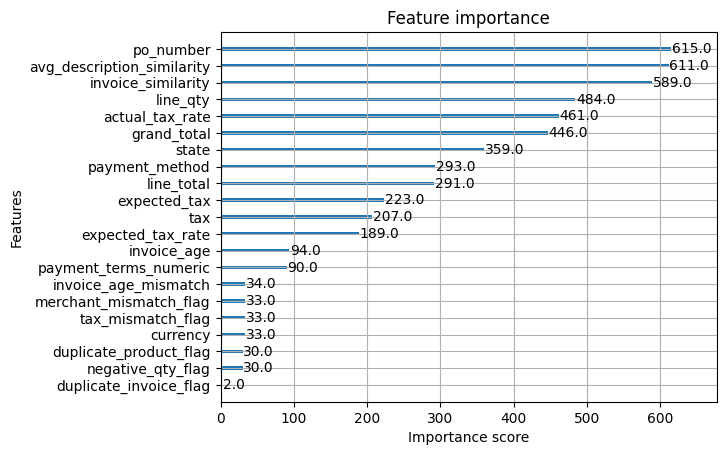

In [51]:
xgb.plot_importance(model)
plt.show()

### Threshold adjustment

In [52]:
# adjust the threshold for is_anomaly
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)  # lower threshold = higher recall

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1177
           1       0.88      0.81      0.85       928

    accuracy                           0.87      2105
   macro avg       0.87      0.86      0.87      2105
weighted avg       0.87      0.87      0.87      2105



### Ensemble learning (bagging)

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Parameters
n_models = 8
seed = 42
_colsample_bytree = [0.8, 1]
_subsample = [0.8, 1]
_max_depth = [5, 6]
models = []
predictions = []

# Train multiple models
for cb in _colsample_bytree:
    for ss in _subsample:
        for md in _max_depth:
            model = XGBClassifier(
                colsample_bytree=cb,
                learning_rate=0.3,
                max_depth=md,
                subsample=ss,
                n_estimators=200,
                random_state=seed,
                eval_metric='logloss',
                scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1])
            )
            model.fit(X_train, y_train)
            models.append(model)
            
            # Predict probabilities
            y_proba = model.predict_proba(X_test)[:, 1]
            predictions.append(y_proba)

# Average predicted probabilities
avg_proba = np.mean(predictions, axis=0)

# Apply threshold (adjustable)
y_pred_ensemble = (avg_proba >= 0.3).astype(int)

# Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Accuracy: 0.876959619952494

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1177
           1       0.90      0.81      0.85       928

    accuracy                           0.88      2105
   macro avg       0.88      0.87      0.87      2105
weighted avg       0.88      0.88      0.88      2105



In [64]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Parameters
n_models = 5
seeds = [42, 52, 62, 72, 82]  # different seeds
models = []
predictions = []

# Train multiple models
for seed in seeds:
    model = XGBClassifier(
            colsample_bytree=0.8,
            learning_rate=0.3,
            max_depth=6,
            subsample=1,
            n_estimators=200,
            random_state=seed,
            eval_metric='logloss',
            scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1])
    )
    model.fit(X_train, y_train)
    models.append(model)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    predictions.append(y_proba)

# Average predicted probabilities
avg_proba = np.mean(predictions, axis=0)

# Apply threshold (adjustable)
y_pred_ensemble = (avg_proba >= 0.3).astype(int)

# Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Accuracy: 0.8736342042755344

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1177
           1       0.89      0.81      0.85       928

    accuracy                           0.87      2105
   macro avg       0.88      0.87      0.87      2105
weighted avg       0.87      0.87      0.87      2105

